In [52]:
#!pip install -q -U tensorflow==2.19.0

In [53]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers, ops
import seaborn as sns

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)


Number of replicas: 1


# Introduction

**Why did i choose this dataset?**

Predicting Chest X-Rays has been one of the earlier successful implementations of deep learning. It is easy to understand and easy to implement in the clinical workflow. It also is extremely usefull for doctors who are often waiting for a prolonged time in order for radiologists to sort through all the different X-Rays that are done in the different departments. 

I worked as a doctor in a hospital and have seen dozens of X-Rays while watining for the final analysis of a radiologist. Using machine learning for these tasks can help speed up this process and also help reduce the workload on doctors and radiologists. It also helps take away "boring" tasks like analysing Chest X-Rays and free up time for more interesting and maybe urgent things. 

**What is pneumonia?**

Pneumonia is a infection of the tissue of one or both Lungs. It can be caused by various agents ranging from virusses to bacteria and even fungi. It can have varying degree of severity and can be letal if severe. It is commonly diagnosed by X-Ray. Since it is commonly in the differential diagnosis for patients in the emergerncy room aswell as patients admitted to the hospital many X-Rays are performed during a routine shift of a radiologist. 

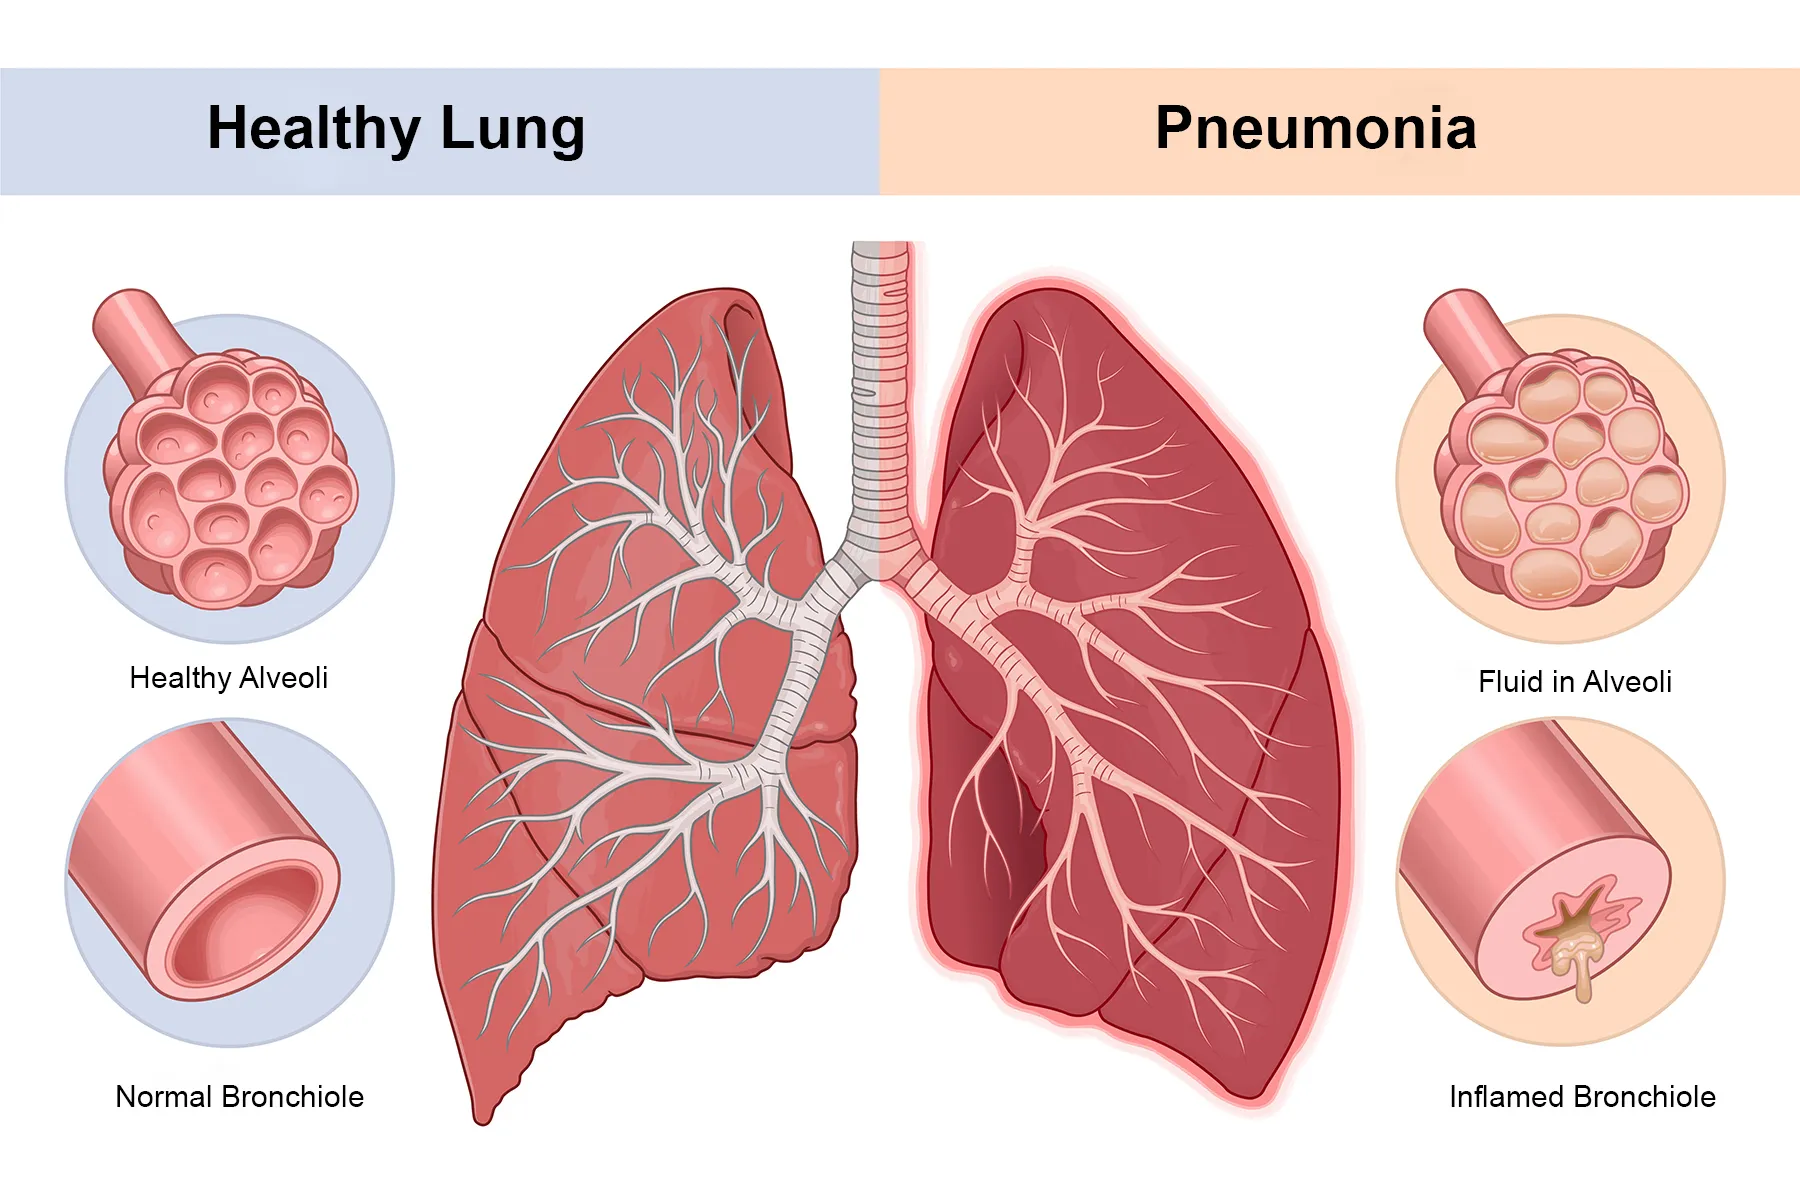

Picture from: https://www.webmd.com/lung/understanding-pneumonia-basics

# Locate and import the data

Now lets start and retrieve the data and get a feeling for how the folders with the data are structure.

In [54]:
print("The working directory is: ", os.getcwd())

The working directory is:  /kaggle/working


**The files are located in the following directory**

In [55]:
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

I will list all the folders in the target directory to see the way the data is stored.

In [56]:
os.listdir(data_dir)

['chest_xray', '__MACOSX', 'val', 'test', 'train']

I will import all the data using the keras dataset import. 

Note: I imported all the data because an earlier version of this notebook used this data for analysis but i found out that it is much more convenient to rely solely on the keras modules and used them later in the notebook to create a generator. 

In [57]:
train,test, val = int(), int(), int()
data = {"train":train,
        "test":test,
        "val": val
    
}

**First data import and data inspection**

In [58]:
batch_size = 32
for ttv in data.keys():
    directory = data_dir + "/" + ttv
    extracted = keras.utils.image_dataset_from_directory(directory = data_dir + "/" + ttv, 
                                                labels="inferred",
                                                label_mode="binary",
                                                class_names=["NORMAL", "PNEUMONIA"],
                                                color_mode="grayscale",
                                                image_size=(150, 150),
                                                batch_size = batch_size)
    data.update({ttv:extracted})
    

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [59]:
print("Unbatching the files")
train = data.get("train").unbatch()
test = data.get("test").unbatch()
val = data.get("val").unbatch()


Unbatching the files


In [60]:
print("Creating train dataset... ")
X_train = np.asarray(list(train.map(lambda x,y: x))) #
y_train = np.asarray(list(train.map(lambda x,y: y)))

print("Creating test dataset... ")
X_test = np.asarray(list(test.map(lambda x,y: x)))
y_test = np.asarray(list(test.map(lambda x,y: y)))

print("Creating validation dataset... ")
X_val = np.asarray(list(val.map(lambda x,y: x)))
y_val = np.asarray(list(val.map(lambda x,y: y)))

Creating train dataset... 
Creating test dataset... 
Creating validation dataset... 


**Pixel values**

Next i will need to find out what the minimum and the maximum values for the pixels are.

In [61]:
for i in enumerate(train.take(3)):
    arry = i[1][0].numpy()
    print("Min: ", np.min(arry))
    print("Max: ", np.max(arry))

Min:  0.0
Max:  254.58467
Min:  0.0
Max:  254.472
Min:  9.96543
Max:  254.57614


The pixels of the images seem to be in a spectrum between 0 and 255. Therefore we will need to normalize the pixel values to have values between 0 an 1.

**Data distribution**

Now we need to find out if the data is distributed evenly or needs weight adjustment for the two different classes. 

In [62]:
print("Number of pictures with pneumonia: ", len(np.where(y_train >0)[1]))
print("Number of pictures without pneumonia: ",len(np.where(y_train == 0)[1]))

Number of pictures with pneumonia:  3875
Number of pictures without pneumonia:  1341


So we need to adjust the data. We have a distribution of about 75% of the pictures showing patients with oneumonia and 25% of the pictures whowing healthy pictures of lungs. 

In [63]:
print("Lets have a look at the first entry in our training data: ", X_train[1])

print("")

print("The minimum value in the data is: ", np.min(X_train), "and the maximum value is: ",  np.max(X_train))

Lets have a look at the first entry in our training data:  [[[3.9351601e+01]
  [8.1663216e+01]
  [7.1183990e+01]
  ...
  [3.0885540e+01]
  [3.4111710e+01]
  [4.9476688e+01]]

 [[5.2156799e+01]
  [8.3934814e+01]
  [9.2583992e+01]
  ...
  [3.5481575e+01]
  [2.5801241e+01]
  [5.0751202e+01]]

 [[5.5239998e+01]
  [1.0291202e+02]
  [1.0069998e+02]
  ...
  [3.2639526e+01]
  [1.3769938e+01]
  [5.6927437e+01]]

 ...

 [[1.0000000e+00]
  [1.9400005e+00]
  [1.0000038e-01]
  ...
  [1.5299243e+00]
  [3.3601367e+00]
  [1.5963242e+00]]

 [[1.0000000e+00]
  [1.9400005e+00]
  [1.0000038e-01]
  ...
  [1.0000000e+00]
  [7.0873671e+00]
  [1.0000000e+00]]

 [[1.0000000e+00]
  [9.4000053e-01]
  [1.0000038e-01]
  ...
  [1.0000000e+00]
  [1.0000000e+00]
  [0.0000000e+00]]]

The minimum value in the data is:  0.0 and the maximum value is:  255.0


# Data visualisation



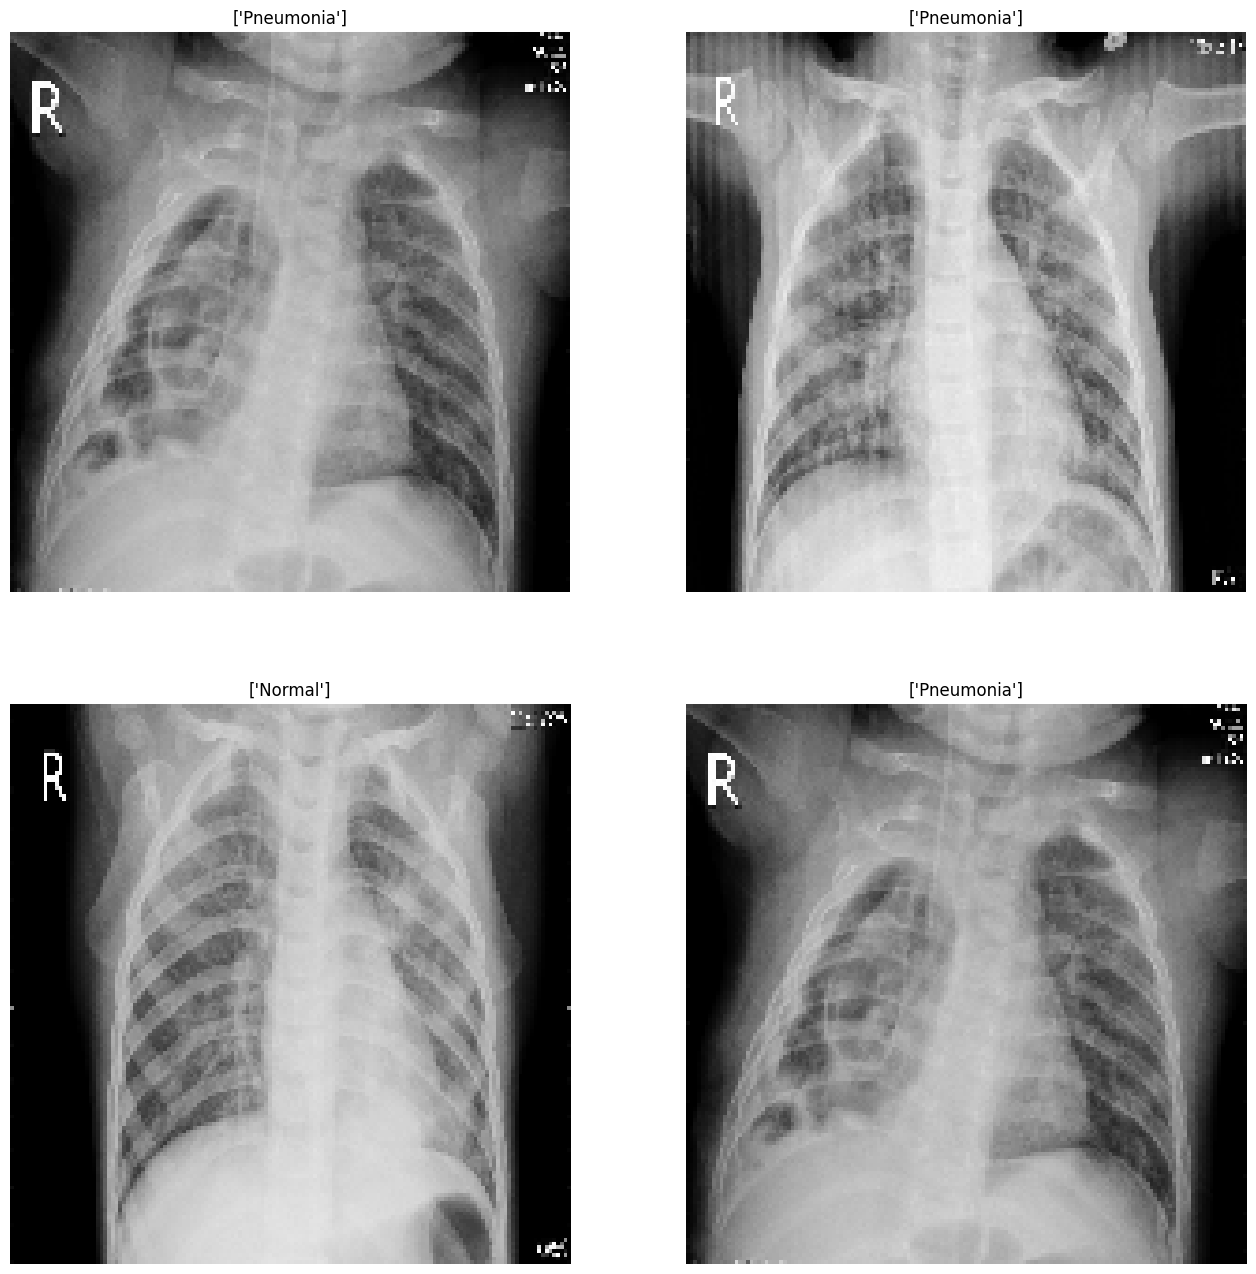

In [64]:
_, ax = plt.subplots(2, 2, figsize=(16, 16))

for i in range(0,2):
    ax[i,0].imshow(X_train[i+2],cmap = "gray")
    ax[i, 0].set_title(np.where(y_train[i+2] == 0, "Normal", "Pneumonia")) #
    ax[i, 0].axis("off")
    
    ax[i,1].imshow(X_train[i+1],cmap = "gray")
    ax[i, 1].set_title(np.where(y_train[i+1] == 0, "Normal", "Pneumonia"))
    ax[i, 1].axis("off")

    
    
    

In [65]:
print(X_train.shape)
print(y_train.shape)

(5216, 150, 150, 1)
(5216, 1)


Now lets free up the memory from the variables i created earlier

In [66]:
del train, test, val, X_train, y_train, X_test, y_test, X_val #y_val

# Data import and augmentation pipeline

Now i created an image augmentation object using the imageDataGenerator from keras. It allows the images to be augmented in a random fashion in order to reduce overfitting and allowing the model to learn features that can be generalized better.

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale = 1./255, # here the rescaling to values between 0 and 1 is applied
        #rotation_range = 30, 
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        #horizontal_flip = True,  
        vertical_flip=False)  

test_val_datagen = ImageDataGenerator(
        rescale = 1./255
)

**Data generator**

The directory and the specifics of the images i want are then entered into the flow from directory method. 

In [68]:
train_generator = train_datagen.flow_from_directory(
    directory= data_dir + "/"  + "train/",
    target_size=(250, 250),
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=4790
)

test_generator = test_val_datagen.flow_from_directory(
    directory= data_dir + "/" + "test",
    target_size=(250, 250),
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=4790
)

valid_generator = test_val_datagen.flow_from_directory(
    directory= data_dir + "/"  + "val",
    target_size=(250, 250),
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=4790
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Model

In [69]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, AveragePooling2D,SeparableConv2D



In [70]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size=3,strides = 2, padding = "valid", activation = "relu", #
                 input_shape= (250,250,1)))
model.add(Conv2D(filters = 16, kernel_size=3,strides = 2, padding = "valid", activation = "relu"))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size = 2 , strides = 2 , padding = 'valid'))
model.add(Conv2D(filters = 32, kernel_size=3,strides = 2, padding = "valid", activation = "relu"))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size = 2 , strides = 2 , padding = 'valid'))
model.add(Conv2D(filters = 128, kernel_size=3,strides = 2, padding = "valid", activation = "relu"))
model.add(MaxPool2D(pool_size = 2 , strides = 2 , padding = 'valid'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 4, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 124, 124, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 3, 3, 128)      │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,401 (169.54 KB)

 Trainable params: 43,401 (169.54 KB)

 Non-trainable params: 0 (0.00 B)

None


**Customised optimizer**

I decided to customise the optimizer in order to find the best features. I used different learning rates and tried to use momentum with different values until i found the correct values i used to build this model.

In [72]:
from keras.optimizers import Adam

optimizer = Adam(
    learning_rate = 0.0001
    #use_ema = True,
    #ema_momentum=0.99
)

**Learning rate scheduler**

I applied a learning rate scheduler to my models since early models took some time to learn the features and used >30 epochs. Later models don't make use of the optimizer but i still kept it. 

In [73]:
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        print(round(model.optimizer.learning_rate, 5))
        return float(lr * ops.exp(-0.1))
        

#callback = keras.callbacks.LearningRateScheduler(scheduler)

**Early stopping**

The second callback i implemented was early stopping after two iterations withoud validation loss improvement, which helped tremendously in later models in order to reduce computation time.

In [74]:
callbacks = [
    keras.callbacks.EarlyStopping(
    #    # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    ),
    keras.callbacks.LearningRateScheduler(scheduler)
]

In [75]:
model.compile(optimizer = optimizer , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [76]:
history = model.fit(train_generator, epochs = 15, callbacks=callbacks,validation_data = test_generator, class_weight = {0:3 , 1:1})

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 331ms/step - accuracy: 0.4538 - loss: 1.0457 - val_accuracy: 0.6298 - val_loss: 0.6806 - learning_rate: 1.0000e-04
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 330ms/step - accuracy: 0.5998 - loss: 0.9872 - val_accuracy: 0.7965 - val_loss: 0.6152 - learning_rate: 1.0000e-04
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 328ms/step - accuracy: 0.7030 - loss: 0.8710 - val_accuracy: 0.8093 - val_loss: 0.5500 - learning_rate: 1.0000e-04
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 327ms/step - accuracy: 0.7769 - loss: 0.7416 - val_accuracy: 0.8077 - val_loss: 0.5014 - learning_rate: 1.0000e-04
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 325ms/step - accuracy: 0.7759 - loss: 0.7004 - val_accuracy: 0.8221 - val_loss: 0.4510 - learning_rate: 1.0000e-04
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 326ms/step - accuracy: 0.8136 - loss: 0.6349 - val_accuracy: 0.8173 - val_loss: 0.4399 - learning_rate: 1.0000e-04
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 32

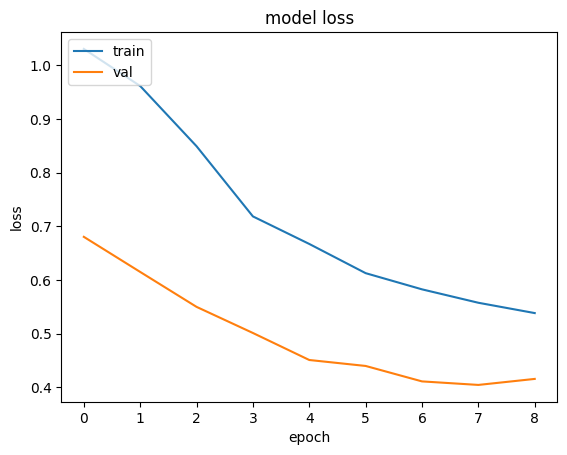

In [77]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

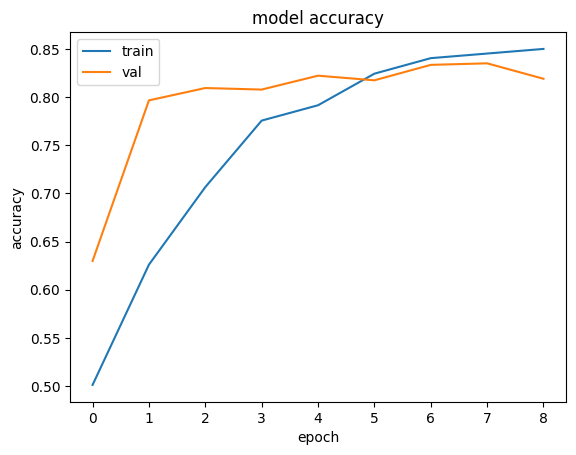

In [78]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Predict on Validation data

I decided to train the data on the train dataset and use the testing dataset as validation. This was done due to the validation dataset being very small. I withheld the validation data and used it as a test dataset.

In [79]:
results = model.evaluate(valid_generator)
print("test loss, test acc:", results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8125 - loss: 0.4251
test loss, test acc: [0.42507272958755493, 0.8125]


# Analysis

As can be seen the model achieves a very good accuracy score of 81.25%. The validation data contains 16 images being dived into 1/2 showing cases with pneumonia and 1/2 showing cases without pneumonia. Therefore the models is able to achieve a substantial increase in correct classification versus a model that would classify each image randomly into one class. 

The model also shows a slowdown in loss decrease and accuracy increase after approximately 9 epochs and reaches a plateu at approximately epoch 14. 15 epochs was chosen as cutoff due to results of earlier models that showed early signs of overfitting at epoch 15. 

In [108]:
pred_prob = model.predict(valid_generator)

pred_class = np.where(pred_prob > 0.5, 1, 0)
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
[[1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]]


In [109]:
print(pred_prob)

[[0.7150007 ]
 [0.82477075]
 [0.40855524]
 [0.7637192 ]
 [0.67742866]
 [0.6861673 ]
 [0.68029445]
 [0.7446579 ]
 [0.30003408]
 [0.16320035]
 [0.42351392]
 [0.31211445]
 [0.16857998]
 [0.32305336]
 [0.51933694]
 [0.86945724]]


In [101]:
imgs, y_val = next(valid_generator)

In [102]:
print(y_val)

[1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]


In [103]:
valid_generator.class_indices.keys()

dict_keys(['NORMAL', 'PNEUMONIA'])

Validation accuracy is:  0.8125


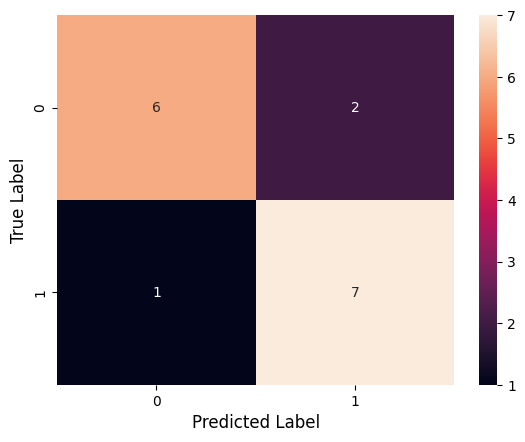

In [110]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve


print("Validation accuracy is: ", accuracy_score(y_val, pred_class))

confusion_matrix = confusion_matrix(y_val, pred_class)

sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [111]:
print(metrics.classification_report(y_val, pred_class, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.78      0.88      0.82         8

    accuracy                           0.81        16
   macro avg       0.82      0.81      0.81        16
weighted avg       0.82      0.81      0.81        16



The Area under the curve is:  0.8125


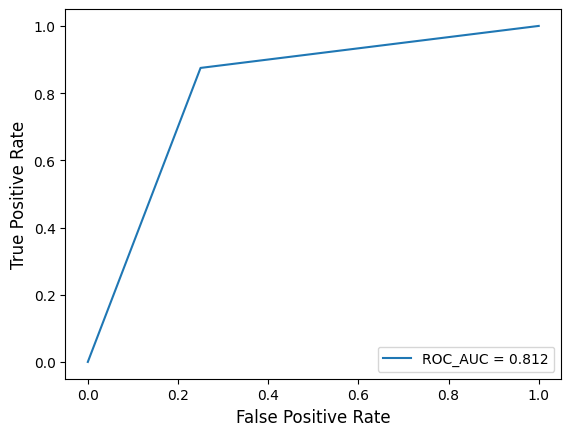

In [112]:
roc_auc = metrics.roc_auc_score(y_val, pred_class)
print('The Area under the curve is: ', roc_auc)

fpr, tpr, thresholds = roc_curve(y_val, pred_class)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()